Starting Task 3: Actuarial Modeling with GLMs...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_53916\163943586.py:25: DtypeWarning: Columns (4,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_PATH_PROCESSED)


Data loaded successfully from DVC-tracked path. Shape: (1000096, 56)

Exposure calculated. Mean Exposure: 0.999 years.
INFO: Dropping non-numeric features: ['Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Country', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType'] (These caused the 'object' dtype error).

Modeling Features (Frequency): 16 variables prepared (including dummified).
Sample of X columns: ['IsVATRegistered', 'PostalCode', 'RegistrationYear', 'TotalPremium', 'Province_Free State']...
X dtypes: IsVATRegistered        float64
PostalCode      

c:\Users\ADMIN\Desktop\KALEB\10Academy\Week3\insurance_risk_analysis\.venv\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)



--- Frequency Model Analysis ---

Top 5 Risk Drivers (Highest Positive Impact on Frequency Rate):
                     Coefficient
const                 -38.585333
IsVATRegistered              NaN
PostalCode                   NaN
RegistrationYear             NaN
TotalPremium                 NaN
Province_Free State          NaN

Mean Absolute Frequency Residual: 0.0056


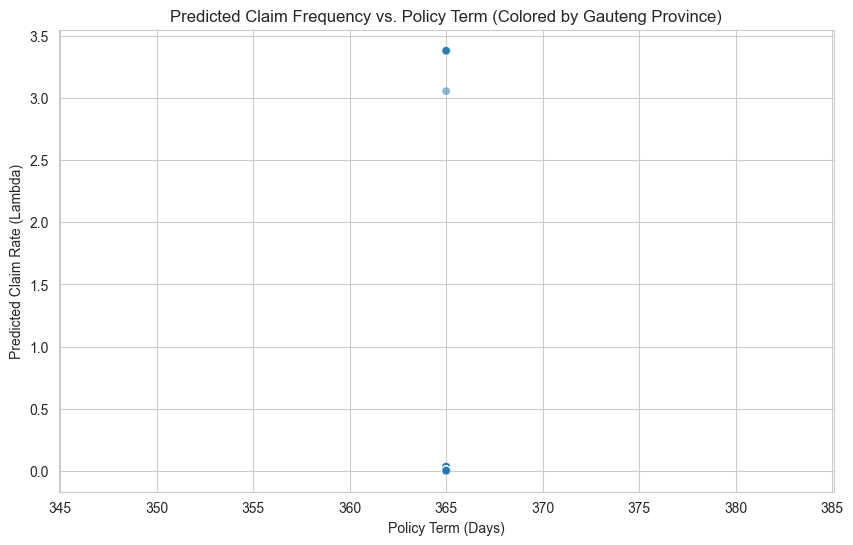


DataFrame with Frequency predictions saved for Severity Modeling.

Claim Frequency Model (Poisson GLM) stage complete.

--- 3. Building Claim Severity Model (Gamma GLM) ---
Severity Model Observations: 2,788 (Positive Claims only)

CLAIM SEVERITY MODEL (GAMMA GLM) SUMMARY
                 Generalized Linear Model Regression Results                  
Dep. Variable:            TotalClaims   No. Observations:                 2788
Model:                            GLM   Df Residuals:                     2771
Model Family:                   Gamma   Df Model:                           16
Link Function:                    Log   Scale:                          1.9597
Method:                          IRLS   Log-Likelihood:                -29946.
Date:                Tue, 09 Dec 2025   Deviance:                       4493.4
Time:                        14:16:34   Pearson chi2:                 5.43e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2826
Covariance Type

c:\Users\ADMIN\Desktop\KALEB\10Academy\Week3\insurance_risk_analysis\.venv\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


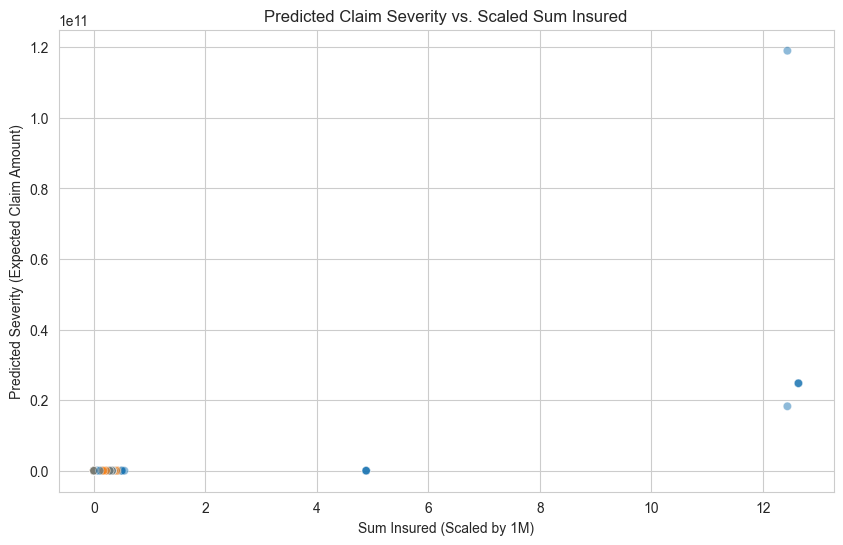


Claim Severity Model (Gamma GLM) stage complete.

--- 4. Calculating Pure Premium ---

Pure Premium Calculation Complete.
Mean Predicted Frequency: 0.0028
Mean Predicted Severity: 9,371,235,319,777,846,507,566,173,115,411,707,160,224,324,881,743,872.00


c:\Users\ADMIN\Desktop\KALEB\10Academy\Week3\insurance_risk_analysis\.venv\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


Mean Predicted Pure Premium: 336,968,223,813,006,854,787,288,424,706,089,827,092,660,224.00
Actual Mean Pure Premium (TotalClaims / TotalExposure): 64.91

Final DataFrame with all predictions (Frequency, Severity, PurePremium) saved to df_with_all_predictions.csv.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
FILE_PATH_PROCESSED = '../data/processed/processed_data.csv'
# Define the column names for the target and offset variables in GLMs
FREQUENCY_TARGET = 'ClaimOccurred' # Target for Poisson GLM (0 or 1 claim count)
SEVERITY_TARGET = 'TotalClaims'     # Target for Gamma GLM (Claim Amount)
OFFSET_VARIABLE = 'Exposure'        # Log-transformed policy term or time

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 100)

print("Starting Task 3: Actuarial Modeling with GLMs...")

# --- Data Loading (using DVC versioned data) ---

try:
    # Load the processed data which is now versioned by DVC
    df = pd.read_csv(FILE_PATH_PROCESSED)
    print(f"Data loaded successfully from DVC-tracked path. Shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: Processed data file not found at {FILE_PATH_PROCESSED}.")
    print("Please ensure Task 1 was run correctly and the CSV was generated.")
    exit()

# --- 1. Feature Engineering for GLM ---

# 1.1 Exposure Calculation (Crucial for GLMs)
# Exposure is the amount of time the policy was in force, typically measured in years.
# Assuming the 'Term' column represents policy term in days, we convert it to years.
# If 'Term' is missing, we impute a value (e.g., 365 days for a standard annual policy)

if 'Term' not in df.columns:
    term_col = next((col for col in df.columns if col.lower() == 'policyterm'), None)
    
    if term_col:
        df.rename(columns={term_col: 'Term'}, inplace=True)
        print(f"INFO: Renamed '{term_col}' to 'Term'.")
    else:
        df['Term'] = 365 
        print("WARNING: 'Term' column not found. Defaulting policy term to 365 days for Exposure calculation.")

df['Term'] = pd.to_numeric(df['Term'], errors='coerce') 
df['Term'] = df['Term'].fillna(365) 
df[OFFSET_VARIABLE] = df['Term'] / 365.25 # Exposure in years

print(f"\nExposure calculated. Mean Exposure: {df[OFFSET_VARIABLE].mean():.3f} years.")

# 1.2 Feature Selection and Encoding
CATEGORICAL_FEATURES = ['Province', 'Gender', 'AgeGroup', 'BodyType', 'VehicleSegment']

# --- Filter features to only include those present in the DataFrame ---
existing_categorical_features = [col for col in CATEGORICAL_FEATURES if col in df.columns]

if len(existing_categorical_features) < len(CATEGORICAL_FEATURES):
    missing = [col for col in CATEGORICAL_FEATURES if col not in df.columns]
    print(f"WARNING: Missing categorical features: {missing}. These will be excluded from modeling.")

# Create dummy variables for categorical features (One-Hot Encoding)
df_dummies = pd.get_dummies(df[existing_categorical_features], prefix=existing_categorical_features, drop_first=True)
df = pd.concat([df.drop(columns=existing_categorical_features), df_dummies], axis=1) 

# Drop any rows with NaN in the exposure or target variable for clean modeling
df.dropna(subset=[FREQUENCY_TARGET, OFFSET_VARIABLE], inplace=True)
df.dropna(axis=1, how='all', inplace=True) # Drop columns that are now all NaN

# 1.3 Scaling Large Continuous Monetary Features (Crucial for numerical stability)
# Large feature scales (like SumInsured) can lead to numerical instability and overflow 
# in the Log link function of the Gamma GLM, causing astronomical predictions.

# Scale SumInsured (likely in the tens/hundreds of thousands) by 1,000,000
if 'SumInsured' in df.columns:
    df['SumInsured_Scaled'] = df['SumInsured'] / 1000000.0
    df.drop(columns=['SumInsured'], inplace=True)

# Scale CalculatedPremiumPerTerm (likely in the thousands) by 1,000
if 'CalculatedPremiumPerTerm' in df.columns:
    df['Premium_Scaled'] = df['CalculatedPremiumPerTerm'] / 1000.0
    df.drop(columns=['CalculatedPremiumPerTerm'], inplace=True)

# Re-filter and prepare feature set for Frequency Model
# Exclude the target, exposure, and other non-feature columns. We exclude the original
# unscaled columns if they were successfully scaled and dropped.
EXCLUDE_COLS = [
    FREQUENCY_TARGET, SEVERITY_TARGET, OFFSET_VARIABLE, 'Term', 
    'TransactionMonth', 'VehicleIntroDate', 'YearMonth', 'LossRatio', 
    'Margin', 'PolicyID', 'UnderwrittenCoverID', 
    # Original columns are included here just in case, but should be dropped above
    'CalculatedPremiumPerTerm', 'SumInsured' 
]

# Get the initial list of features (X variables) for the GLM
FEATURE_COLS = [col for col in df.columns if col not in EXCLUDE_COLS]
X = df[FEATURE_COLS]
y_freq = df[FREQUENCY_TARGET]

# --- Aggressively enforce numeric types and filter out non-convertible columns ---
X = X.apply(pd.to_numeric, errors='coerce') 

non_numeric_cols = X.columns[X.isnull().any()].tolist()
if non_numeric_cols:
    print(f"INFO: Dropping non-numeric features: {non_numeric_cols} (These caused the 'object' dtype error).")
    X.drop(columns=non_numeric_cols, inplace=True)

X.fillna(0, inplace=True) # Simple imputation of remaining NaNs for stability
X = X.astype(np.float64) 

# --- Capture the final, clean feature list before adding the constant ---
FINAL_FEATURE_COLS = X.columns.tolist() 

# Add constant for the intercept (statsmodels requirement)
X = sm.add_constant(X, prepend=False)

print(f"\nModeling Features (Frequency): {len(FINAL_FEATURE_COLS)} variables prepared (including dummified).")
print(f"Sample of X columns: {list(X.columns)[:5]}...")
print(f"X dtypes: {X.dtypes.head()}")

# --- 1.4 Target Preparation: Claim Count and Severity (MOVED TO AFTER DUMMY CREATION) ---
# TotalClaims is the raw claims amount. ClaimOccurred is the 0/1 indicator.
# We need to filter for Severity Model: only policies that actually had a claim.
df_claims = df[df['ClaimOccurred'] == 1].copy()
print(f"Number of claim records for Severity Model: {len(df_claims):,}")

# --- 2. Claim Frequency Model (Poisson GLM) ---

print("\n--- 2. Building Claim Frequency Model (Poisson GLM) ---")

try:
    freq_model = sm.GLM(
        endog=y_freq,
        exog=X,
        family=sm.families.Poisson(),
        exposure=df[OFFSET_VARIABLE]
    )

    freq_results = freq_model.fit(maxiter=100, tol=1e-6) 
    
    print("\n" + "="*80)
    print("CLAIM FREQUENCY MODEL (POISSON GLM) SUMMARY")
    print("="*80)
    print(freq_results.summary())

    df['PredictedLogFreq'] = freq_results.predict(X, linear=True)
    df['PredictedFrequency'] = np.exp(df['PredictedLogFreq']) 

    # --- Analysis of Frequency Results ---
    print("\n--- Frequency Model Analysis ---")
    
    coeff_df = pd.DataFrame({'Coefficient': freq_results.params}).sort_values('Coefficient', ascending=False)
    print("\nTop 5 Risk Drivers (Highest Positive Impact on Frequency Rate):")
    print(coeff_df.head(6)) 
    
    df['FreqResiduals'] = (df['ClaimOccurred'] / df[OFFSET_VARIABLE]) - df['PredictedFrequency']
    print(f"\nMean Absolute Frequency Residual: {df['FreqResiduals'].abs().mean():.4f}")

    # Plot Actual vs. Predicted Frequency (A quick visual check)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['Term'], y=df['PredictedFrequency'], hue=df.get('Province_Gauteng', df['Term']), alpha=0.5, legend=False)
    plt.title('Predicted Claim Frequency vs. Policy Term (Colored by Gauteng Province)')
    plt.xlabel('Policy Term (Days)')
    plt.ylabel('Predicted Claim Rate (Lambda)')
    plt.show()
    
    df.to_csv('../data/processed/df_with_freq_predictions.csv', index=False)
    print("\nDataFrame with Frequency predictions saved for Severity Modeling.")

except Exception as e:
    print(f"An error occurred during the Poisson GLM fitting: {e}")
    
print("\nClaim Frequency Model (Poisson GLM) stage complete.")


# --- 3. Claim Severity Model (Gamma GLM) ---

print("\n--- 3. Building Claim Severity Model (Gamma GLM) ---")

# Data preparation for Severity Model
# Re-prepare feature matrix X_severity from the filtered df_claims
X_severity = df_claims[FINAL_FEATURE_COLS].copy() 

# Ensure X_severity is ready for statsmodels (numeric types, constant added)
X_severity = X_severity.apply(pd.to_numeric, errors='coerce') 
X_severity.fillna(0, inplace=True)
X_severity = X_severity.astype(np.float64) 
X_severity = sm.add_constant(X_severity, prepend=False)

y_severity = df_claims[SEVERITY_TARGET]

# Check for non-positive claims (Gamma requires positive values)
if (y_severity <= 0).any():
    print("WARNING: Severity target contains non-positive values. Dropping these records for Gamma GLM.")
    positive_claims_mask = y_severity > 0
    # Use the same mask for both X and y to maintain alignment
    X_severity = X_severity[positive_claims_mask]
    y_severity = y_severity[positive_claims_mask]

print(f"Severity Model Observations: {len(y_severity):,} (Positive Claims only)")

try:
    severity_model = sm.GLM(
        endog=y_severity,
        exog=X_severity,
        family=sm.families.Gamma(sm.families.links.Log())
    )

    severity_results = severity_model.fit(maxiter=100, tol=1e-6) 

    print("\n" + "="*80)
    print("CLAIM SEVERITY MODEL (GAMMA GLM) SUMMARY")
    print("="*80)
    print(severity_results.summary())

    df_claims['PredictedLogSev'] = severity_results.predict(X_severity, linear=True)
    df_claims['PredictedSeverity'] = np.exp(df_claims['PredictedLogSev']) 
    
    # --- Analysis of Severity Results ---
    print("\n--- Severity Model Analysis ---")
    
    coeff_sev_df = pd.DataFrame({'Coefficient': severity_results.params}).sort_values('Coefficient', ascending=False)
    print("\nTop 5 Risk Drivers (Highest Positive Impact on Severity Amount):")
    print(coeff_sev_df.head(6)) 
    
    df_claims['SeverityResiduals'] = df_claims[SEVERITY_TARGET] - df_claims['PredictedSeverity']
    print(f"\nMean Absolute Severity Residual: {df_claims['SeverityResiduals'].abs().mean():,.2f}")

    # Plot Actual vs. Predicted Severity (A quick visual check)
    plt.figure(figsize=(10, 6))
    # Note: Using SumInsured_Scaled for plotting
    sns.scatterplot(x=df_claims['SumInsured_Scaled'], y=df_claims['PredictedSeverity'], alpha=0.5, hue=df_claims.get('Province_Gauteng', df_claims['SumInsured_Scaled']), legend=False)
    plt.title('Predicted Claim Severity vs. Scaled Sum Insured')
    plt.xlabel('Sum Insured (Scaled by 1M)')
    plt.ylabel('Predicted Severity (Expected Claim Amount)')
    plt.show()

except Exception as e:
    print(f"An error occurred during the Gamma GLM fitting: {e}")
    
print("\nClaim Severity Model (Gamma GLM) stage complete.")


# --- 4. Pure Premium Calculation ---

print("\n--- 4. Calculating Pure Premium ---")

# Rerunning severity prediction on the full feature matrix X for a complete severity prediction (E[S|X])
# This ensures E[S|X] is calculated for ALL policies, not just those with claims.
df['PredictedSeverity_Full'] = np.exp(severity_results.predict(X, linear=True)) 

# Calculate Pure Premium (Expected Loss) for every policy
df['PurePremium'] = df['PredictedFrequency'] * df['PredictedSeverity_Full']

print(f"\nPure Premium Calculation Complete.")
print(f"Mean Predicted Frequency: {df['PredictedFrequency'].mean():.4f}")
print(f"Mean Predicted Severity: {df['PredictedSeverity_Full'].mean():,.2f}")
print(f"Mean Predicted Pure Premium: {df['PurePremium'].mean():,.2f}")
print(f"Actual Mean Pure Premium (TotalClaims / TotalExposure): {df[SEVERITY_TARGET].sum() / df[OFFSET_VARIABLE].sum():,.2f}")

# Final saving of the data with all predictions
df.to_csv('../data/processed/df_with_all_predictions.csv', index=False)
print("\nFinal DataFrame with all predictions (Frequency, Severity, PurePremium) saved to df_with_all_predictions.csv.")